In [3]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt



In [6]:
# Loading transactional order data
orders_df = pd.read_csv("orders.csv")

# Preview data
orders_df.head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name
0,1,2508,450,18-02-2023,842.97,New Foods Chinese
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian


In [7]:
# Loading user master data
users_df = pd.read_json("users.json")

# Normalize in case of nested JSON
users_df = pd.json_normalize(users_df)

users_df.head()


""
0
1
2
3


In [8]:
# Loading restaurant master data from SQL
conn = sqlite3.connect(":memory:")

with open("restaurants.sql", "r") as file:
    conn.executescript(file.read())

restaurants_df = pd.read_sql_query(
    "SELECT * FROM restaurants", conn
)

conn.close()

restaurants_df.head()


,restaurant_id,restaurant_name,cuisine,rating
0,1,Restaurant_1,Chinese,4.8
1,2,Restaurant_2,Indian,4.1
2,3,Restaurant_3,Mexican,4.3
3,4,Restaurant_4,Chinese,4.1
4,5,Restaurant_5,Chinese,4.8


In [13]:
# Merging orders with users (LEFT JOIN)
merged_df = orders_df.merge(
    users_df,
    on="user_id",
    how="left"
)

# Merging with restaurants data (LEFT JOIN)
final_df = merged_df.merge(
    restaurants_df,
    on="restaurant_id",
    how="left"
)

final_df.head()


,order_id,user_id,restaurant_id,order_date,total_amount,restaurant_name_x,name,city,membership,restaurant_name_y,cuisine,rating
0,1,2508,450,18-02-2023,842.97,New Foods Chinese,User_2508,Hyderabad,Regular,Restaurant_450,Mexican,3.2
1,2,2693,309,18-01-2023,546.68,Ruchi Curry House Multicuisine,User_2693,Pune,Regular,Restaurant_309,Indian,4.5
2,3,2084,107,15-07-2023,163.93,Spice Kitchen Punjabi,User_2084,Chennai,Gold,Restaurant_107,Mexican,4.0
3,4,319,224,04-10-2023,1155.97,Darbar Kitchen Non-Veg,User_319,Bangalore,Gold,Restaurant_224,Chinese,4.8
4,5,1064,293,25-12-2023,1321.91,Royal Eatery South Indian,User_1064,Pune,Regular,Restaurant_293,Italian,3.0


In [10]:
print("Orders columns:")
print(orders_df.columns)

print("\nUsers columns:")
print(users_df.columns)


Orders columns:
Index(['order_id', 'user_id', 'restaurant_id', 'order_date', 'total_amount',
       'restaurant_name'],
      dtype='object')

Users columns:
Index([], dtype='object')


In [11]:
import json

with open("users.json", "r") as f:
    raw_users = json.load(f)

type(raw_users), raw_users[:1]


(list,
 [{'user_id': 1,
   'name': 'User_1',
   'city': 'Chennai',
   'membership': 'Regular'}])

In [12]:
users_df = pd.DataFrame(raw_users)
users_df.head()


,user_id,name,city,membership
0,1,User_1,Chennai,Regular
1,2,User_2,Pune,Gold
2,3,User_3,Bangalore,Gold
3,4,User_4,Bangalore,Regular
4,5,User_5,Pune,Gold


In [14]:
# Saving final combined dataset
final_df.to_csv("final_food_delivery_dataset.csv", index=False)


C:\Users\manoj\AppData\Local\Temp\ipykernel_25660\2090912278.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  final_df['order_date'] = pd.to_datetime(final_df['order_date'])


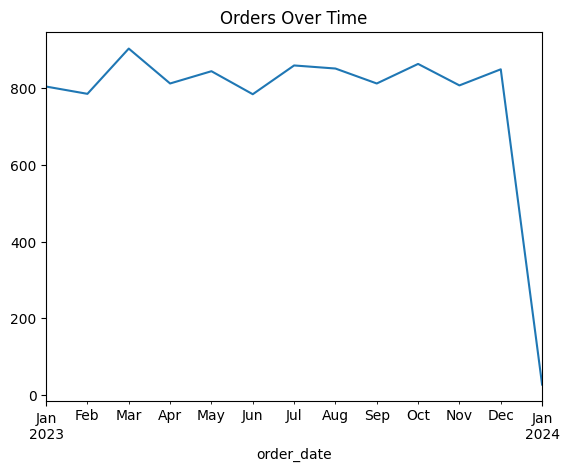

In [15]:
final_df['order_date'] = pd.to_datetime(final_df['order_date'])

orders_over_time = final_df.groupby(
    final_df['order_date'].dt.to_period('M')
).size()

orders_over_time.plot(kind='line', title='Orders Over Time')
plt.show()


In [16]:
import pandas as pd

df = pd.read_csv("final_food_delivery_dataset.csv")

# Standard cleanup
df.columns = df.columns.str.lower().str.strip()
df['order_date'] = pd.to_datetime(df['order_date'])


C:\Users\manoj\AppData\Local\Temp\ipykernel_25660\3005577101.py:7: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['order_date'] = pd.to_datetime(df['order_date'])


In [17]:
gold_city_revenue = (
    df[df['membership'] == 'Gold']
    .groupby('city')['total_amount']
    .sum()
    .sort_values(ascending=False)
)

gold_city_revenue


city
Chennai      1080909.79
Pune         1003012.32
Bangalore     994702.59
Hyderabad     896740.19
Name: total_amount, dtype: float64

In [18]:
avg_order_by_cuisine = (
    df.groupby('cuisine')['total_amount']
    .mean()
    .sort_values(ascending=False)
)

avg_order_by_cuisine

cuisine
Mexican    808.021344
Italian    799.448578
Indian     798.466011
Chinese    798.389020
Name: total_amount, dtype: float64

In [19]:
user_spending = (
    df.groupby('user_id')['total_amount']
    .sum()
)

count_users = (user_spending > 1000).sum()
count_users


np.int64(2544)

In [20]:
bins = [3.0, 3.5, 4.0, 4.5, 5.0]
labels = ['3.0–3.5', '3.6–4.0', '4.1–4.5', '4.6–5.0']

df['rating_range'] = pd.cut(df['rating'], bins=bins, labels=labels)

rating_revenue = (
    df.groupby('rating_range')['total_amount']
    .sum()
    .sort_values(ascending=False)
)

rating_revenue


C:\Users\manoj\AppData\Local\Temp\ipykernel_25660\1563437694.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('rating_range')['total_amount']


rating_range
4.6–5.0    2197030.75
4.1–4.5    1960326.26
3.0–3.5    1881754.57
3.6–4.0    1717494.41
Name: total_amount, dtype: float64

In [21]:
gold_avg_city = (
    df[df['membership'] == 'Gold']
    .groupby('city')['total_amount']
    .mean()
    .sort_values(ascending=False)
)

gold_avg_city


city
Chennai      808.459080
Hyderabad    806.421034
Bangalore    793.223756
Pune         781.162243
Name: total_amount, dtype: float64

In [22]:
cuisine_stats = (
    df.groupby('cuisine')
    .agg(
        distinct_restaurants=('restaurant_id', 'nunique'),
        total_revenue=('total_amount', 'sum')
    )
    .sort_values(['distinct_restaurants', 'total_revenue'], ascending=[True, False])
)

cuisine_stats


,distinct_restaurants,total_revenue
cuisine,,
Chinese,120,1930504.65
Italian,126,2024203.80
Indian,126,1971412.58
Mexican,128,2085503.09


In [23]:
total_orders = len(df)
gold_orders = len(df[df['membership'] == 'Gold'])

percentage = round((gold_orders / total_orders) * 100)
percentage


50

In [28]:
restaurant_col = 'restaurant_name_x'  # or _y depending on print output

restaurant_stats = (
    df.groupby(restaurant_col)
    .agg(
        avg_order_value=('total_amount', 'mean'),
        total_orders=('order_id', 'count')
    )
)

filtered = restaurant_stats[restaurant_stats['total_orders'] < 20]
filtered.sort_values('avg_order_value', ascending=False).head()



,avg_order_value,total_orders
restaurant_name_x,,
Hotel Dhaba Multicuisine,1040.222308,13
Sri Mess Punjabi,1029.180833,12
Ruchi Biryani Punjabi,1002.140625,16
Sri Delights Pure Veg,989.467222,18
Classic Kitchen Family Restaurant,973.167895,19


In [25]:
combo_revenue = (
    df.groupby(['membership', 'cuisine'])['total_amount']
    .sum()
    .sort_values(ascending=False)
)

combo_revenue


membership  cuisine
Regular     Mexican    1072943.30
            Italian    1018424.75
Gold        Mexican    1012559.79
            Italian    1005779.05
Regular     Indian      992100.27
Gold        Indian      979312.31
            Chinese     977713.74
Regular     Chinese     952790.91
Name: total_amount, dtype: float64

In [26]:
df['quarter'] = df['order_date'].dt.to_period('Q')

quarter_revenue = (
    df.groupby('quarter')['total_amount']
    .sum()
    .sort_values(ascending=False)
)

quarter_revenue


quarter
2023Q3    2037385.10
2023Q4    2018263.66
2023Q1    1993425.14
2023Q2    1945348.72
2024Q1      17201.50
Freq: Q-DEC, Name: total_amount, dtype: float64

In [27]:
print(df.columns)


Index(['order_id', 'user_id', 'restaurant_id', 'order_date', 'total_amount',
       'restaurant_name_x', 'name', 'city', 'membership', 'restaurant_name_y',
       'cuisine', 'rating', 'rating_range', 'quarter'],
      dtype='object')


In [32]:
gold_orders_count = df[df['membership'] == 'Gold'].shape[0]
gold_orders_count


4987

In [33]:
hyderabad_revenue = round(
    df[df['city'] == 'Hyderabad']['total_amount'].sum()
)

hyderabad_revenue


1889367

In [34]:
distinct_users = df['user_id'].nunique()
distinct_users


2883

In [35]:
gold_avg_order_value = round(
    df[df['membership'] == 'Gold']['total_amount'].mean(),
    2
)

gold_avg_order_value


np.float64(797.15)

In [36]:
high_rating_orders = df[df['rating'] >= 4.5].shape[0]
high_rating_orders


3374

In [37]:
top_gold_city = (
    df[df['membership'] == 'Gold']
    .groupby('city')['total_amount']
    .sum()
    .idxmax()
)

top_gold_city


'Chennai'

In [38]:
orders_in_top_city = df[
    (df['membership'] == 'Gold') & 
    (df['city'] == top_gold_city)
].shape[0]

orders_in_top_city


1337